# Naive Bayes (the easy way)

We'll cheat by using sklearn.naive_bayes to train a spam classifier! Most of the code is just loading our training data into a pandas DataFrame that we can play with:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

Let's have a look at that DataFrame:

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [4]:
#df = pd.read_csv('dataset.csv', encoding='latin-1')

df = pd.read_csv('convo.csv' ,header=None,error_bad_lines=False)

b'Skipping line 24: expected 2 fields, saw 3\nSkipping line 40: expected 2 fields, saw 3\nSkipping line 116: expected 2 fields, saw 3\nSkipping line 220: expected 2 fields, saw 4\n'


In [5]:
#df.drop([2, 3, 4, 5, 6, 7], axis = 1, inplace = True)
df

,0,1
0,age,how old are you
1,name,what is your name
2,name,what can i call you
3,name,tell me your name ?
4,name,what do people call you
...,...,...
212,bio_question,how are you faring today?
213,bio_question,how is yor family
214,bio_question,how is your lover
215,bio_question,sure you are good?


In [6]:
df.count() 
df.columns = ['label', 'message']

In [7]:
df['label'].count() 

217

In [8]:
# Describing the dataset containing conversaions, and question.
df.groupby('label').describe() 

message                                      
               count unique                       top freq
label                                                     
age               20     19          tell me your age    2
bio_question      43     39               how are you    4
good_reply        40     36                 ok thanks    3
greeting          32     31                  whats up    2
name              40     35         what is your name    3
task              42     34   tell me what you can do    3

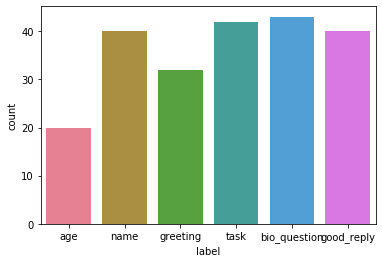

In [9]:
sns.countplot(data=df, x='label')
plt.show() 

In [10]:
df.head(1000) 

,label,message
0,age,how old are you
1,name,what is your name
2,name,what can i call you
3,name,tell me your name ?
4,name,what do people call you
...,...,...
212,bio_question,how are you faring today?
213,bio_question,how is yor family
214,bio_question,how is your lover
215,bio_question,sure you are good?


In [11]:
# Cleaning the text
import string 
from nltk.corpus import stopwords 
from nltk import PorterStemmer as Stemmer
def process(text):
    # turn the texts into lowercase
    text = text.lower() 
    # remove punctuation
    text = ''.join([t for t in text if t not in string.punctuation])
    # remove stopwords 
    text = [t for t in text.split() if t not in stopwords.words('english')]
    # Stemming the words 
    stemmer = Stemmer() 
    text = [stemmer.stem(t) for t in text]
    # Return the token list 
    return text 

Let's try it out:

In [12]:
# testing the function 
process('it is a holiday, and we are playing cricket. jeff is playing very well')

['holiday', 'play', 'cricket', 'jeff', 'play', 'well']

In [13]:
# Testing it against our dataset
df['message'][:20].apply(process)

0              [old]
1             [name]
2             [call]
3       [tell, name]
4      [peopl, call]
5       [pple, call]
6       [tell, call]
7       [tell, call]
8              [far]
9         [yo, what]
10     [hello, aipa]
11     [what, today]
12      [what, dude]
13      [what, aipa]
14             [hey]
15             [hey]
16    [name, answer]
17            [name]
18     [name, pleas]
19      [name, need]
Name: message, dtype: object

In [14]:
# 
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidfv = TfidfVectorizer(analyzer = process)
data = tfidfv.fit_transform(df['message'])

In [16]:
mess_id = df.iloc[2]['message']
print(mess_id)

 what can i call you


In [17]:
print(tfidfv.transform([mess_id]))

  (0, 9)	1.0


In [30]:
## Building a model 
from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import MultinomialNB 
model = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer=process)),
     ('classifier', MultinomialNB())
    
])

In [31]:
# performing a training and a spliting test 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.20, random_state = 21)

In [32]:
# Training the Spam filter 
model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function process at 0x7fac8e040d08>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [33]:
predictions = model.predict(x_test)
model.score(x_test, y_test)

0.8181818181818182

In [36]:
# Defining a function to run and use the model for classfication.
def detect_conversation(s):
    result = model.predict([s])[0]
    #return result
    print(result)

detect_conversation('just tell me your name please ? ')

name


In [73]:
value = ['hello, how far', 'can you find out who that person is?']
for i in value:
    detect_conversation(i)

greeting
task


In [23]:
# Saving the pickle file into memory 
import pickle 
filename = 'question_model.pkl'

In [24]:
# save the model to disk
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.6153846153846154


In [25]:
# Saving the model to disk 
pickle.dump([df, model], open(filename, 'wb'))

In [24]:
import joblib 

# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(model, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(x_test, y_test)
print(result)

0.9302325581395349


In [64]:
from sklearn.externals import joblib
# save the model to disk
filename = 'finalized_model.sav'
 
# load the model from disk
model = joblib.load(filename)

In [65]:
model.predict(['what can you do ?'])[0]

'task'

In [28]:
from sklearn.externals import joblib
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(x_test, y_test)
print(result)

0.2857142857142857


In [23]:
! pip install joblib